# Section 1: Relational Data Model Design & Implementation

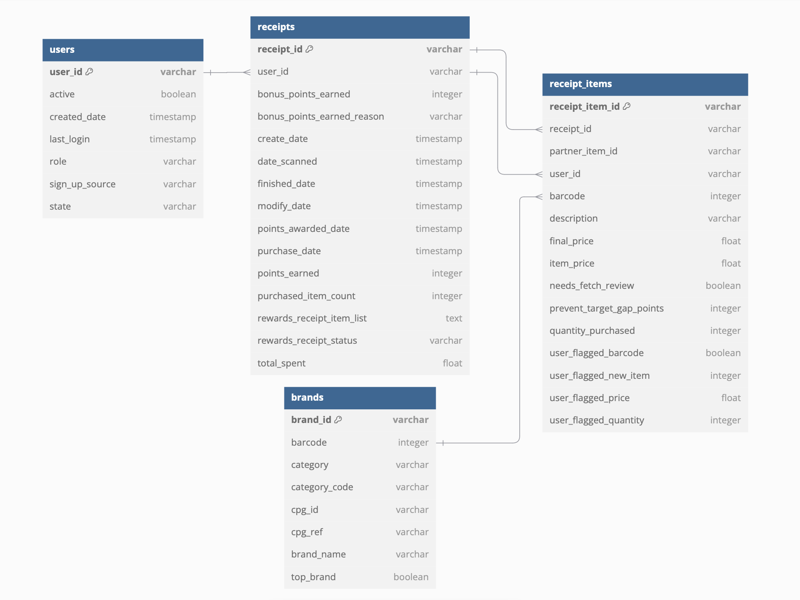

In [50]:
from IPython.display import display
from PIL import Image

img = Image.open("images/er_diagram.png")

display(img.resize((800, 600)))

## Preliminary Data Loading Functions

In [51]:
import json
import pandas as pd
from sqlalchemy import create_engine, text

# Create an in-memory SQLite engine
engine = create_engine('sqlite:///:memory:')

def create_staging_table(table_name):
    """
    Create a staging table with a single column (raw_data) for the given table name.
    """
    create_stmt = f"""
    create table {table_name} (
        raw_data TEXT
    );
    """
    with engine.connect() as conn:
        conn.execute(text(create_stmt))

def load_json_into_table(file_path, table_name):
    """
    Read a JSON file (one JSON object per line) and insert each line
    into the specified staging table.
    """
    # Read non-empty lines from the file
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    with engine.connect() as conn:
        for line in lines:
            conn.execute(
                text(f"insert into {table_name} (raw_data) values (:raw_data)"),
                {"raw_data": line}
            )

def run_query(query):
    """
    Execute the provided SQL query and return the results as a pandas DataFrame.
    """
    return pd.read_sql(query, engine)

## Loading JSON Files into Environment

In [52]:
users_table = "staging_users"
create_staging_table(users_table)
load_json_into_table("datasets/users.json", users_table)


receipts_table = "staging_receipts"
create_staging_table(receipts_table)
load_json_into_table("datasets/receipts.json", receipts_table)


brands_table = "staging_brands"
create_staging_table(brands_table)
load_json_into_table("datasets/brands.json", brands_table)

## SQL to Clean JSON Files

In [53]:
# Process users.json

users_query = text("""
select
    json_extract(raw_data, '$._id.$oid') AS user_id,
    json_extract(raw_data, '$.active') AS active,
    datetime(json_extract(raw_data, '$.createdDate.$date') / 1000, 'unixepoch') AS created_date,
    datetime(json_extract(raw_data, '$.lastLogin.$date') / 1000, 'unixepoch') AS last_login,
    json_extract(raw_data, '$.role') AS role,
    json_extract(raw_data, '$.signUpSource') AS sign_up_source,
    json_extract(raw_data, '$.state') AS state
from staging_users
order by 1;
""")

users = run_query(users_query)
users.head()

,user_id,active,created_date,last_login,role,sign_up_source,state
0,54943462e4b07e684157a532,1,2014-12-19 14:21:22,2021-03-05 16:52:23,fetch-staff,None,None
1,54943462e4b07e684157a532,1,2014-12-19 14:21:22,2021-03-05 16:52:23,fetch-staff,None,None
2,54943462e4b07e684157a532,1,2014-12-19 14:21:22,2021-03-05 16:52:23,fetch-staff,None,None
3,54943462e4b07e684157a532,1,2014-12-19 14:21:22,2021-03-05 16:52:23,fetch-staff,None,None
4,54943462e4b07e684157a532,1,2014-12-19 14:21:22,2021-03-05 16:52:23,fetch-staff,None,None


One thing we immediately notice here is that user_id is not unique, and the rows are duplicated.

We also notice that there are rows where `role = 'fetch-staff'`, which we want to exlclude since they're probably admin users.

To address this, we will deduplicate based on user_id and simply take the first row based on created_date and filter the dataset to only users where `role = 'consumer'`.

In [54]:
# Process users.json

users_query = text("""
with base as (
select
    json_extract(raw_data, '$._id.$oid') AS user_id,
    json_extract(raw_data, '$.active') AS active,
    datetime(json_extract(raw_data, '$.createdDate.$date') / 1000, 'unixepoch') as created_date,
    datetime(json_extract(raw_data, '$.lastLogin.$date') / 1000, 'unixepoch') AS last_login,
    json_extract(raw_data, '$.role') AS role,
    json_extract(raw_data, '$.signUpSource') AS sign_up_source,
    json_extract(raw_data, '$.state') AS state,
    row_number() over (partition by json_extract(raw_data, '$._id.$oid') order by json_extract(raw_data, '$.createdDate.$date') / 1000) as rank_
from staging_users
                   )

select
    user_id,
    active,
    created_date,
    last_login,
    role,
    sign_up_source,
    state
from 
    base 
where rank_ = 1
and role = 'consumer'
order by 1;
""")

users = run_query(users_query)
users.to_sql('users', engine, if_exists='replace', index=False)

users.head()

,user_id,active,created_date,last_login,role,sign_up_source,state
0,55308179e4b0eabd8f99caa2,1,2015-04-17 03:43:53,2018-05-07 17:23:40,consumer,None,WI
1,5a43c08fe4b014fd6b6a0612,1,2017-12-27 15:47:27,2021-02-12 16:22:37,consumer,None,None
2,5e27526d0bdb6a138c32b556,1,2020-01-21 19:35:09,None,consumer,Google,WI
3,5fb0a078be5fc9775c1f3945,1,2020-11-15 03:28:56,None,consumer,Google,AL
4,5ff1e194b6a9d73a3a9f1052,1,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI


In [55]:
# Process brands.json

brands_query = text("""
select
    json_extract(raw_data, '$._id.$oid') as brand_id,
    json_extract(raw_data, '$.barcode') as barcode,
    json_extract(raw_data, '$.category') as category,
    json_extract(raw_data, '$.categoryCode') as category_code,
    json_extract(raw_data, '$.cpg.$id.$oid') as cpg_id,
    json_extract(raw_data, '$.cpg.$ref') as cpg_ref,
    json_extract(raw_data, '$.name') as brand_name,
    json_extract(raw_data, '$.topBrand') as top_brand
from staging_brands;
""")

brands = run_query(brands_query)
brands.to_sql('brands', engine, if_exists='replace', index=False)

brands.head()

,brand_id,barcode,category,category_code,cpg_id,cpg_ref,brand_name,top_brand
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,Cogs,test brand @1612366101024,0.0
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,Starbucks,0.0
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146176,0.0
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146051,0.0
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1612366146827,0.0


In [56]:
# Process receipts.json

receipts_query = text("""
select
    json_extract(raw_data, '$._id.$oid') as receipt_id,
    json_extract(raw_data, '$.userId') as user_id,
    cast(json_extract(raw_data, '$.bonusPointsEarned') as float) as bonus_points_earned,
    json_extract(raw_data, '$.bonusPointsEarnedReason') as bonus_points_earned_reason,
    datetime(json_extract(raw_data, '$.createDate.$date') / 1000, 'unixepoch') as create_date,
    datetime(json_extract(raw_data, '$.dateScanned.$date') / 1000, 'unixepoch') as date_scanned,
    datetime(json_extract(raw_data, '$.finishedDate.$date') / 1000, 'unixepoch') as finished_date,
    datetime(json_extract(raw_data, '$.modifyDate.$date') / 1000, 'unixepoch') as modify_date,
    datetime(json_extract(raw_data, '$.pointsAwardedDate.$date') / 1000, 'unixepoch') as points_awarded_date,
    cast(json_extract(raw_data, '$.pointsEarned') as int) as points_earned,
    datetime(json_extract(raw_data, '$.purchaseDate.$date') / 1000, 'unixepoch') as purchase_date,
    json_extract(raw_data, '$.purchasedItemCount') as purchased_item_count,
    json_extract(raw_data, '$.rewardsReceiptItemList') as rewards_receipt_item_list,
    json_extract(raw_data, '$.rewardsReceiptStatus') as rewards_receipt_status,
    cast(json_extract(raw_data, '$.totalSpent') as float) as total_spent
from staging_receipts;
""")

receipts = run_query(receipts_query)
receipts.to_sql('receipts', engine, if_exists='replace', index=False)

receipts.head(10)

,receipt_id,user_id,bonus_points_earned,bonus_points_earned_reason,create_date,date_scanned,finished_date,modify_date,points_awarded_date,points_earned,purchase_date,purchased_item_count,rewards_receipt_item_list,rewards_receipt_status,total_spent
0,5ff1e1eb0a720f0523000575,5ff1e1eacfcf6c399c274ae6,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,26.00
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,11.00
2,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,None,2021-01-03 15:25:42,None,5.0,2021-01-03 00:00:00,1.0,"[{""needsFetchReview"":false,""partnerItemId"":""1""...",REJECTED,10.00
3,5ff1e1ee0a7214ada100056f,5ff1e1eacfcf6c399c274ae6,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,28.00
4,5ff1e1d20a7214ada1000561,5ff1e194b6a9d73a3a9f1052,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,1.00
5,5ff1e1e40a7214ada1000566,5ff1e1e4cfcf6c399c274ac3,750.0,"Receipt number 1 completed, bonus point schedu...",2021-01-03 15:25:24,2021-01-03 15:25:24,2021-01-03 15:25:25,2021-01-03 15:25:30,2021-01-03 15:25:25,750.0,2021-01-02 15:25:24,1.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,3.25
6,5ff1e1cd0a720f052300056f,5ff1e194b6a9d73a3a9f1052,5.0,All-receipts receipt bonus,2021-01-03 15:25:01,2021-01-03 15:25:01,2021-01-03 15:25:02,2021-01-03 15:25:02,2021-01-03 15:25:02,5.0,2021-01-03 15:25:01,1.0,"[{""brandCode"":""MISSION"",""competitorRewardsGrou...",FINISHED,2.23
7,5ff1e1a40a720f0523000569,5ff1e194b6a9d73a3a9f1052,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:24:20,2021-01-03 15:24:20,2021-01-03 15:24:21,2021-01-03 15:24:21,2021-01-03 15:24:21,500.0,2020-12-27 00:00:00,1.0,"[{""barcode"":""046000832517"",""brandCode"":""BRAND""...",FINISHED,10.00
8,5ff1e1ed0a7214ada100056e,5ff1e1eacfcf6c399c274ae6,5.0,All-receipts receipt bonus,2021-01-03 15:25:33,2021-01-03 15:25:33,2021-01-03 15:25:34,2021-01-03 15:25:38,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,5.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,20.00
9,5ff1e1eb0a7214ada100056b,5ff1e1eacfcf6c399c274ae6,250.0,"Receipt number 3 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,250.0,2021-01-03 00:00:00,3.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,20.00


In [57]:
# We use SQLite's json_each() to "explode" the JSON array.
receipt_items_query = text("""
with cleaned as (
  select
    pr.receipt_id,
    pr.user_id,
    json_extract(item.value, '$.barcode') as barcode,
    json_extract(item.value, '$.description') as description,
    json_extract(item.value, '$.finalPrice') as final_price,
    json_extract(item.value, '$.itemPrice') as item_price,
    json_extract(item.value, '$.needsFetchReview') as needs_fetch_review,
    json_extract(item.value, '$.partnerItemId') as partner_item_id,
    json_extract(item.value, '$.preventTargetGapPoints') as prevent_target_gap_points,
    json_extract(item.value, '$.quantityPurchased') as quantity_purchased,
    json_extract(item.value, '$.userFlaggedBarcode') as user_flagged_barcode,
    json_extract(item.value, '$.userFlaggedNewItem') as user_flagged_new_item,
    json_extract(item.value, '$.userFlaggedPrice') as user_flagged_price,
    json_extract(item.value, '$.userFlaggedQuantity') as user_flagged_quantity,
    (pr.receipt_id || coalesce(json_extract(item.value, '$.partnerItemId'), '')) as receipt_item_id
  from receipts as pr,
       json_each(pr.rewards_receipt_item_list) as item
)
select
  receipt_item_id,
  receipt_id,
  partner_item_id,
  user_id,
  barcode,
  description,
  final_price,
  item_price,
  needs_fetch_review,
  prevent_target_gap_points,
  quantity_purchased,
  user_flagged_barcode,
  user_flagged_new_item,
  user_flagged_price,
  user_flagged_quantity
from cleaned;
""")

receipt_items = run_query(receipt_items_query)
receipt_items.to_sql('receipt_items', engine, if_exists='replace', index=False)

receipt_items.head(10)

,receipt_item_id,receipt_id,partner_item_id,user_id,barcode,description,final_price,item_price,needs_fetch_review,prevent_target_gap_points,quantity_purchased,user_flagged_barcode,user_flagged_new_item,user_flagged_price,user_flagged_quantity
0,5ff1e1eb0a720f05230005751,5ff1e1eb0a720f0523000575,1,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,26.00,26.00,0.0,1.0,5.0,4011,1.0,26.00,5.0
1,5ff1e1bb0a720f052300056b1,5ff1e1bb0a720f052300056b,1,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,NaN,1.0,None,NaN,None,NaN
2,5ff1e1bb0a720f052300056b2,5ff1e1bb0a720f052300056b,2,5ff1e194b6a9d73a3a9f1052,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,1.0,1.0,1.0,028400642255,1.0,10.00,1.0
3,5ff1e1f10a720f052300057a1,5ff1e1f10a720f052300057a,1,5ff1e1f1cfcf6c399c274b0b,None,None,None,None,0.0,1.0,NaN,4011,1.0,26.00,3.0
4,5ff1e1ee0a7214ada100056f1,5ff1e1ee0a7214ada100056f,1,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,28.00,28.00,0.0,1.0,4.0,4011,1.0,28.00,4.0
5,5ff1e1d20a7214ada10005611,5ff1e1d20a7214ada1000561,1,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,NaN,1.0,None,NaN,None,NaN
6,5ff1e1d20a7214ada10005612,5ff1e1d20a7214ada1000561,2,5ff1e194b6a9d73a3a9f1052,1234,None,2.56,2.56,1.0,1.0,3.0,1234,1.0,2.56,3.0
7,5ff1e1e40a7214ada10005661,5ff1e1e40a7214ada1000566,1,5ff1e1e4cfcf6c399c274ac3,4011,ITEM NOT FOUND,3.25,3.25,0.0,1.0,1.0,4011,NaN,None,NaN
8,5ff1e1cd0a720f052300056f1009,5ff1e1cd0a720f052300056f,1009,5ff1e194b6a9d73a3a9f1052,None,MSSN TORTLLA,2.23,2.23,NaN,NaN,1.0,None,NaN,None,NaN
9,5ff1e1a40a720f05230005690,5ff1e1a40a720f0523000569,0,5ff1e194b6a9d73a3a9f1052,046000832517,"Old El Paso Mild Chopped Green Chiles, 4.5 Oz",10.00,10.00,NaN,NaN,1.0,None,NaN,None,NaN


# Section 2: Business Question Answering

## Receipt Analysis

Here, we will attempt to answer the following questions:
* When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
* When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

To accomplish this, we will do a simple grouping of the receipts table by their rewards_receipt_status and calculate both the average spend and the number of items purchased.

In [58]:
rewards_status_query = """
select
    rewards_receipt_status,
    round(avg(total_spent),2) as avg_spend,
    sum(purchased_item_count) as items_purchased,
    count(*) as receipts
from receipts
group by 1
order by 4 desc
"""

rewards_status_stats = run_query(rewards_status_query)
rewards_status_stats.to_sql('rewards_status_stats', engine, if_exists='replace', index=False)

rewards_status_stats

,rewards_receipt_status,avg_spend,items_purchased,receipts
0,FINISHED,80.85,8184.0,518
1,SUBMITTED,NaN,NaN,434
2,REJECTED,23.33,173.0,71
3,PENDING,28.03,NaN,50
4,FLAGGED,180.45,1014.0,46


One thing we immediately notice with the output above is that the `Accepted` value does not exist in the receipts table. Upon inspecting the possible values, `Finished` seems to be the field with the same definition. We will bring this up in the Slack email later on, but for now we will assume `Accepted` is the same as `Finished` and use that to answer the questions below

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [59]:
avg_spend_query = """
select
    rewards_receipt_status,
    avg_spend
from rewards_status_stats
where rewards_receipt_status in ('FINISHED', 'REJECTED')
"""

avg_spend_results = run_query(avg_spend_query)

avg_spend_results

,rewards_receipt_status,avg_spend
0,FINISHED,80.85
1,REJECTED,23.33


Answer: The former is greater. Receipts with `rewards_receipt_status = 'FINISHED'` have higher average spend compared to those where `rewards_receipt_status = 'REJECTED'`

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?


In [60]:
items_purchased_query = """
select
    rewards_receipt_status,
    items_purchased
from rewards_status_stats
where rewards_receipt_status in ('FINISHED', 'REJECTED')
"""

items_purchased_query = run_query(items_purchased_query)

items_purchased_query

,rewards_receipt_status,items_purchased
0,FINISHED,8184.0
1,REJECTED,173.0


Answer: The former is greater. There are more total items purchased among receipts with `rewards_receipt_status = 'FINISHED'` compared to those where `rewards_receipt_status = 'REJECTED'`

## Brand Analysis

Here, we will attempt to answer the following questions:
* Which brand has the most spend among users who were created within the past 6 months?
* Which brand has the most transactions among users who were created within the past 6 months?

The first thing we notice here is that the last recorded login of any user is `2021-03-05` and there are no records of anything after that date. This suggests that the 'past 6 months' subset of users should be looked at relative to that date instead of today.

To make the analysis below meaningful, 'today' will be set to `2021-03-05`. 

To accomplish this, we will first inner join the `receipt_items` table with the users table on the `user_id` key and also add another conditional requiring the user to have been created at least 6 months before 'today'. With both the barcode and spend recorded, we can attch that information to the brand table, where we can use the barcode to obtain the brand name before aggregating and obtaining the relevant metrics.

In [61]:
brand_performance_query = """
with eligible_user_purchases as (
    select
        coalesce(ri.barcode, ri.user_flagged_barcode) as barcode,
        ri.final_price as spend
    from users u
    inner join receipt_items ri
    on u.user_id = ri.user_id
    and created_date > date((select max(last_login) from users), '-6 months')
)

select
    coalesce(b.brand_name, 'no_match') as brand,
    sum(e.spend) as total_spend,
    count(*) as transactions
from brands b
full outer join eligible_user_purchases e
on b.barcode = e.barcode
group by 1
order by 2 desc
"""

brand_performance = run_query(brand_performance_query)
brand_performance.to_sql('brand_performance', engine, if_exists='replace', index=False)
brand_performance.head()

,brand,total_spend,transactions
0,no_match,29935.50,3983
1,Cracker Barrel Cheese,196.98,2
2,Tostitos,80.66,23
3,Swanson,61.38,11
4,Cheetos,22.00,1


Here, I see that almost 4000 transactions were unmatched, which is magnitudes greater than the number of matched transactions. To address this, I'll return the item sold directly if there is no match.

In [62]:
brand_performance_query_adj = """
with eligible_user_purchases as (
    select
        coalesce(ri.barcode, ri.user_flagged_barcode) as barcode,
        ri.description,
        ri.final_price as spend
    from users u
    inner join receipt_items ri
    on u.user_id = ri.user_id
    and created_date > date((select max(last_login) from users), '-6 months')
)

select
    coalesce(b.brand_name, e.description) as brand,
    sum(e.spend) as total_spend,
    count(*) as transactions
from brands b
full outer join eligible_user_purchases e
on b.barcode = e.barcode
group by 1
order by 2 desc
"""

brand_performance_adj = run_query(brand_performance_query_adj)
brand_performance_adj.to_sql('brand_performance_adj', engine, if_exists='replace', index=False)
brand_performance_adj.head()

,brand,total_spend,transactions
0,ITEM NOT FOUND,1470.15,121
1,MILLER LITE 24 PACK 12OZ CAN,1453.00,53
2,None,1155.52,206
3,KLARBRUNN 12PK 12 FL OZ,920.82,92
4,Chestnuts,720.00,4


### Which brand has the most spend among users who were created within the past 6 months?

In [63]:
brand_performance_spend = """
select
    brand,
    total_spend
from brand_performance
order by 2 desc
"""

brand_performance_spend = run_query(brand_performance_spend)

brand_performance_spend.head(5)

,brand,total_spend
0,no_match,29935.50
1,Cracker Barrel Cheese,196.98
2,Tostitos,80.66
3,Swanson,61.38
4,Cheetos,22.00


In [82]:
brand_performance_spend_adj = """
select
    brand,
    total_spend
from brand_performance_adj
order by 2 desc
"""

brand_performance_spend_adj = run_query(brand_performance_spend_adj)

brand_performance_spend_adj.head(5)

,brand,total_spend
0,ITEM NOT FOUND,1470.15
1,MILLER LITE 24 PACK 12OZ CAN,1453.00
2,None,1155.52
3,KLARBRUNN 12PK 12 FL OZ,920.82
4,Chestnuts,720.00


Answer: Among the matched brands, Cracker Barrel Cheese is the brand with the most speend among users created within the past 6 months. However, Miller Lite seems to be the actual brand with the most spend among users when we account for unmatched brands.

### Which brand has the most transactions among users who were created within the past 6 months?

In [65]:
brand_performance_tx = """
select
    brand,
    transactions
from brand_performance
order by 2 desc
"""

brand_performance_tx = run_query(brand_performance_tx)
brand_performance_tx.head(5)

,brand,transactions
0,no_match,3983
1,Tostitos,23
2,Swanson,11
3,Kettle Brand,3
4,Pepperidge Farm,3


In [83]:
brand_performance_tx_adj = """
select
    brand,
    transactions
from brand_performance_adj
order by 2 desc
"""

brand_performance_tx_adj = run_query(brand_performance_tx_adj)
brand_performance_tx_adj.head(5)

,brand,transactions
0,None,206
1,ITEM NOT FOUND,121
2,KLARBRUNN 12PK 12 FL OZ,92
3,KLEENEX POP UP RECTANGLE BOX FACIAL TISSUE 2 P...,69
4,REGULAR PEPSI SODA COLA CAN 12 CT 144 OZ,63


Answer: Among the matched brands, Tostitos is the brand with the most transactions among users created within the past 6 months. However, Klarbrunn seems to be the actual brand with the most transactions among users when we account for unmatched brands.

# Section 3: Data Quality Investigation

## DQ Investigation: users table

Here we will first do some simple data quality checks, first checking for null values across the table.

In [66]:
users_dq_1 = """
select
    count(*) as rows,
    sum(case when active is null then 1 else 0 end) as active_null,
    sum(case when created_date is null then 1 else 0 end) as created_date_null,
    sum(case when last_login is null then 1 else 0 end) as last_login_null,
    sum(case when role is null then 1 else 0 end) as role_null,
    sum(case when sign_up_source is null then 1 else 0 end) as sign_up_source_null,
    sum(case when state is null then 1 else 0 end) as state_null
from users
"""

null_dq = run_query(users_dq_1)

null_dq.head()

,rows,active_null,created_date_null,last_login_null,role_null,sign_up_source_null,state_null
0,204,0,0,40,0,2,3


Here, we notice that there are 40 null values in the last_login column, 5 null values in the sign_up_source column, and 6 null values in the state column.

Next, I'll conduct an evaluation on some columns that seem especially relevant: `state` and `created_date`. Confirming these fields are trustworthy will enable the team to better measure marketing campaigns, user behaviors, and promote more effective decision making.

In [67]:
users_dq_2 = """
select
    state,
    count(*) as rows
from users
group by 1
order by 2 desc
"""

state_dq = run_query(users_dq_2)

state_dq.head(10)

,state,rows
0,WI,191
1,AL,4
2,None,3
3,IL,2
4,SC,1
5,OH,1
6,KY,1
7,CO,1


Here, we notice that the distribution of `state` among the users provided is very skewed towards Wisconsin. This might be a result of some kind of truncation before the dataset was provided.

In [68]:
users_dq_3 = """
select
    strftime('%Y-%m-01', created_date) as user_created_month, 
    count(*)
from users
group by 1
order by 1 desc;
"""

user_created_dq = run_query(users_dq_3)

user_created_dq.head(20)

,user_created_month,count(*)
0,2021-02-01,30
1,2021-01-01,170
2,2020-11-01,1
3,2020-01-01,1
4,2017-12-01,1
5,2015-04-01,1


We also notice that the users are mostly created in early 2021 and nowhere else. This skewed distribution also raises some cause for conern.

In [69]:
users_dq_4 = """
with diffs as (
select
    created_date,
    last_login,
    (strftime('%s', last_login) - strftime('%s', created_date))/(3600*24) AS diff_days
from users)

select
    diff_days,
    count(*) as users
from diffs
group by 1
order by 2 desc;
"""

last_login_dq = run_query(users_dq_4)

last_login_dq.head(20)

,diff_days,users
0,0.0,162
1,NaN,40
2,1143.0,1
3,1116.0,1


As a result, we don't observe any cases where the last login was between 1 and 119 days since the user creation date

To summarize, here are some key potential DQ issues with the users table:
* Duplicated `user_id`,
* null `last_login`, `sign_up_source`, `state`
* skewed `state` to be mainly Wisconsin
* skewed user distribution to 2021 January, no users in 2018-2019
* no cases where last login in between 1 and 119 days since user creation date

## DQ Investigation: Receipts table

In this section, I will write Python code to investigate data quality issues

### Points Awarded
There seem to be two potential issues relating to the bonus_points_earned column
* no points earned despite showing `rewards_receipt_status = 'FINISHED'`
* distribution of points seem very concentrated around two ranges (0-100 and ~750), with very little receipts awarded points in between these two areas.

In [70]:
receipts[(receipts['rewards_receipt_status'] == 'FINISHED') & (receipts['bonus_points_earned'].isna())]

,receipt_id,user_id,bonus_points_earned,bonus_points_earned_reason,create_date,date_scanned,finished_date,modify_date,points_awarded_date,points_earned,purchase_date,purchased_item_count,rewards_receipt_item_list,rewards_receipt_status,total_spent
32,5ff36c750a7214ada100058f,5ff36be7135e7011bcb856d3,NaN,None,2021-01-04 19:28:53,2021-01-04 19:28:53,2021-01-04 19:28:54,2021-01-04 19:28:54,2021-01-04 19:28:54,500.0,2021-01-03 19:28:53,9.0,"[{""barcode"":""029000079236"",""description"":""PLAN...",FINISHED,89.91
35,5ff36adb0a720f0523000590,5ff36a3862fde912123a4460,NaN,None,2021-01-04 19:22:03,2021-01-04 19:22:03,2021-01-04 19:22:04,2021-01-04 19:22:04,2021-01-04 19:22:04,250.0,2020-12-30 06:00:00,5.0,"[{""barcode"":""044700009888"",""description"":""OSCA...",FINISHED,49.95
52,5ff3713c0a7214ada10005b6,5ff370c562fde912123a5e0e,NaN,None,2021-01-04 19:49:16,2021-01-04 19:49:16,2021-01-04 19:49:16,2021-01-04 19:49:16,2021-01-04 19:49:16,350.0,2021-01-03 19:49:16,1.0,"[{""barcode"":""044700019917"",""description"":""OSCA...",FINISHED,10.00
70,5ff473b10a7214ada10005c4,5ff47392c3d63511e2a47881,NaN,None,2021-01-05 14:12:01,2021-01-05 14:12:01,2021-01-05 14:12:01,2021-01-05 14:12:01,2021-01-05 14:12:01,250.0,2021-01-02 06:00:00,5.0,"[{""barcode"":""021000068364"",""description"":""JUST...",FINISHED,49.95
76,5ff473f60a7214ada10005ce,5ff47392c3d63511e2a47881,NaN,None,2021-01-05 14:13:10,2021-01-05 14:13:10,2021-01-05 14:13:11,2021-01-05 14:13:11,2021-01-05 14:13:11,250.0,2020-12-31 06:00:00,5.0,"[{""barcode"":""044700030479"",""description"":""OSCA...",FINISHED,49.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,601485340a720f05f8000167,60147d2ac8b50e11d8453f53,NaN,None,2021-01-29 21:59:16,2021-01-29 21:59:16,2021-01-29 21:59:16,2021-02-01 17:31:02,2021-01-29 21:59:16,209.0,2021-01-29 00:00:00,1.0,"[{""barcode"":""036000320893"",""description"":""HUGG...",FINISHED,20.99
643,601485370a720f05f8000172,60147d2ac8b50e11d8453f53,NaN,None,2021-01-29 21:59:19,2021-01-29 21:59:19,2021-01-29 21:59:19,2021-02-01 17:31:05,2021-01-29 21:59:19,209.0,2021-01-29 00:00:00,1.0,"[{""barcode"":""036000320893"",""description"":""HUGG...",FINISHED,20.98
664,601485370a720f05f8000175,60147d2ac8b50e11d8453f53,NaN,None,2021-01-29 21:59:19,2021-01-29 21:59:19,2021-01-29 21:59:20,2021-02-01 17:47:09,2021-01-29 21:59:20,210.0,2021-01-29 00:00:00,1.0,"[{""barcode"":""036000320893"",""description"":""HUGG...",FINISHED,21.00
667,6014853a0a7214ad50000106,60147d2ac8b50e11d8453f53,NaN,None,2021-01-29 21:59:22,2021-01-29 21:59:22,2021-01-29 21:59:23,2021-02-01 17:47:14,2021-01-29 21:59:23,209.0,2021-01-29 00:00:00,1.0,"[{""barcode"":""036000320893"",""description"":""HUGG...",FINISHED,20.95


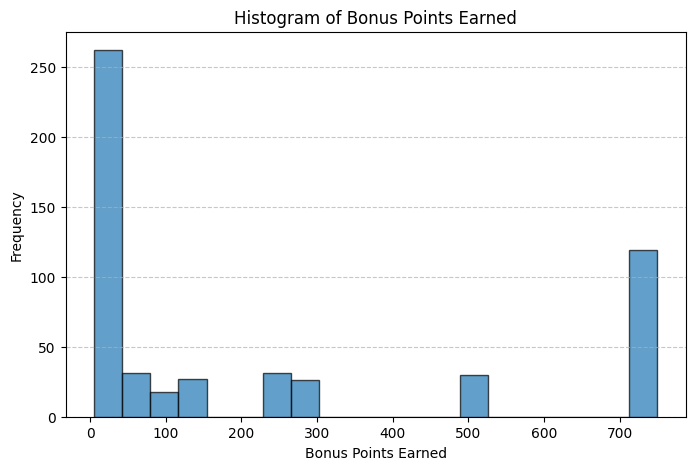

In [71]:
import matplotlib.pyplot as plt

# Assuming receipts is your DataFrame
plt.figure(figsize=(8, 5))
plt.hist(receipts['bonus_points_earned'].dropna(), bins=20, edgecolor='black', alpha=0.7)

plt.xlabel('Bonus Points Earned')
plt.ylabel('Frequency')
plt.title('Histogram of Bonus Points Earned')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


## Stats By Receipt Status

This may not be an issue, but pending receipts don't have any records of items purchased or points earned. 

We also see that SUBMITTED receipts doesn't even have the total spent field recorded. This may be because the receipts haven't been scanned, but this seems like something I'd follow up about

In [72]:
receipts.groupby('rewards_receipt_status').agg(
    avg_total_spent=('total_spent', 'mean'),
    avg_purchased_item_count=('purchased_item_count', 'mean'),
    avg_points_earned=('bonus_points_earned', 'mean')
)

,avg_total_spent,avg_purchased_item_count,avg_points_earned
rewards_receipt_status,,,
FINISHED,80.854305,15.799228,240.839912
FLAGGED,180.451739,22.043478,452.166667
PENDING,28.032449,NaN,NaN
REJECTED,23.326056,2.436620,113.275862
SUBMITTED,NaN,NaN,NaN


To summarize, here are some key potential DQ issues with the receipts table:
* no points earned despite showing `rewards_receipt_status = 'FINISHED'`
* points distribution strongly concentrated around two small ranges
* PENDING receipts don't have records of items purchased or points earned
* SUBMITTED receipts don't have records of total spent, items purchased, or points earned

## DQ Investigation: Brands Table

First, I'll investigate the most important columns for determining the category of brands people have been purhcasing: `category` and `category_brand`. To do this, we'll look at all the category:category pairs

In [73]:
category_grouped = brands.groupby(['category', 'category_code'], dropna=False).size().reset_index(name='count')

category_grouped.head(10)

,category,category_code,count
0,Baby,BABY,7
1,Baby,NaN,11
2,Baking,BAKING,359
3,Baking,NaN,10
4,Beauty,NaN,9
5,Beauty & Personal Care,NaN,6
6,Beer Wine Spirits,BEER_WINE_SPIRITS,31
7,Beer Wine Spirits,NaN,59
8,Beverages,BEVERAGES,1
9,Beverages,NaN,62


Here, we surprisingly see multiple cases of the same category not being mapped the same category code.

For example, there are 11 cases of `category = Baby` not being mapped to `category_code = BABY` and 59 cases of` category = Beer Wine Spirits` not being mapped to `category_code = BEER_WINE_SPIRITS`

In [74]:
category_grouped.tail()

,category,category_code,count
28,Outdoor,OUTDOOR,1
29,Personal Care,PERSONAL_CARE,4
30,Personal Care,NaN,16
31,Snacks,NaN,75
32,NaN,NaN,155


We also observe 155 cases of brands not having any category or category code.

Next, looking at the dataframe, I noticed many instances of `brand_name` having the `test_brand` prefix. This may not be an issue if it's intended for the brands to not yet have a name, but it's something I'd bring up in a data quality meeting as well.

Next, I'll investigate how top_brand is distributed

In [75]:
brands.groupby(['top_brand'], dropna=False).size().reset_index(name='count')

,top_brand,count
0,0.0,524
1,1.0,31
2,NaN,612


While it makes sense most brands aren't considered "top", over half of the brands have this field marked as null. They should either be coalesced to 0 or there's some failed mapping with some other tables in the database.

In [76]:
brands.groupby(brands['barcode'].astype(str).str[:5]).size().reset_index(name='count')

,barcode,count
0,51111,1167


It's also pretty interesting that all the barcodes in the brands table start with '51111'. I'd imagine this is a DQ issue as well. 

To summarize, here are some key potential DQ issues with the brands table:
* some categories don't map to their category codes 
* brands with null `category` & `category_code`
* many cases of `brand_name` having "test brand" prefix
* brands with null `top_brand`
* barcode only starts with `51111`

## DQ Investigation: Receipt Items Table

I'll first follow up on the barcode investigation in the previous codeblock to see if the same '51111' trend applies to the receipt_items table.

In [77]:
barcode_prefix = receipt_items.groupby(receipt_items['barcode'].str[:5]) \
    .size() \
    .reset_index(name='count') \
    .sort_values(by='count', ascending=False)

barcode_prefix.head(12)

,barcode,count
26,02100,240
50,03600,190
159,4011,177
73,04300,171
129,07684,125
196,75450,107
8,01200,99
155,31111,98
41,02840,91
48,03410,90


Here, we notice that most barcodes in the receipt_items table don't start with `51111` -- it's only the 11th most common prefix. This raises serious questions about the brands table not storing all the brands. 

Next we'll look at some simple distributions of key columns

In [78]:
receipt_items.groupby(['needs_fetch_review'], dropna=False).size().reset_index(name='count')

,needs_fetch_review,count
0,0.0,594
1,1.0,219
2,NaN,6128


In [79]:
receipt_items.groupby(['user_flagged_barcode'], dropna=False).size().reset_index(name='count')

,user_flagged_barcode,count
0,028400642255,13
1,034100573065,166
2,075925306254,9
3,079400066619,10
4,1234,32
5,4011,107
6,NaN,6604


In [80]:
receipt_items.groupby(['user_flagged_new_item'], dropna=False).size().reset_index(name='count')

,user_flagged_new_item,count
0,1.0,323
1,NaN,6618


In [81]:
receipt_items.groupby(['user_flagged_quantity'], dropna=False).size().reset_index(name='count')

,user_flagged_quantity,count
0,1.0,189
1,2.0,29
2,3.0,31
3,4.0,30
4,5.0,20
5,NaN,6642


To summarize, here are some key potential DQ issues with the receipt items table:
* much wider space of barcodes, which means many items won't be joinable to the `brands` table
    * more of a `brands` table issue
* multiple cases of `needs_fetch_review` being null when 0 and 1 are observed values
* multiple cases `user_flagged_barcode`, `user_flagged_new_item`, and `user_flagged_quantity` being null
    * may not be an issue since it seems to rely on users actively flagging a field

# Section 4: Stakeholder Communication

Here, I'll write an email to a product/business leader who isn't familiar with my day to day work.

To make it a bit more realistic, I'll set Jasper Seldin (Ranking & Relevance PM) as the recipient of this email.

Hi Jasper,

Hope this email finds you well.

I've been looking through some of our core tables (*receipts*, *users*, and *brands*) and using them to answer some business questions.

In the process, I found some potential data quality issues that limited my confidence in presenting the findings to stakeholders.

You can find the details in section 3 of [`responses.ipynb`](link), but the most striking ones include:

- **[users]** `user_id` is non-unique
- **[users]** Most users were created in January 2021 and are from Wisconsin
- **[receipts]** Strongly bimodal distribution of points awarded in the receipts table
- **[brands]** Brands table only has barcodes that begin with `51111`
- **[receipt items]** Most barcodes in the receipts items table don't begin with `51111`

I found these potential issues by first identifying the most intuitively important columns, then looking at missing data rates, distribution of non-null fields, and column-level relationships with other tables.

The main question I have is whether these issues are expected or not – if not, here are some follow-up questions that would better help me address the issues:
- Has anyone on the integrations team recently flagged an integration issue porting data from S3 to Snowflake?
- What should the distribution of bonus points awarded look like? Are there cases 
- Are there states that we don't operate in? What are some of the most important states in terms of revenue?

Additionally, I heard about the ML workflows you and the company have in mind, and I'd love to support that effort by optimizing the data transformation processes in these tables.

To that end, I have the following questions:

- How often does your team (and the business) query these tables?
- Do you (or the business) anticipate having to generate multiple complex queries downstream of these tables?
- How important is it that the data is up to date?  Or can you tolerate the latest data being delayed by a few hours for your use case? What about a day?

This is on the more AE side of things, but your answers here will allow me to better understand whether to materialize these data assets as views, incrementals, or tables and determine the optimal cadence of full-refreshing these tables as they get much larger.

As we scale, we anticipate longer data update runtimes as table dependencies become more complex, big/slow tables begin blocking parallelizable downstream tasks, and technical debt limits meaningful refactors to speed up runtime.

To address these, we'll do the following to further improve the business' experience with data as we continue to scale:

- Standardize and optimize the way we assign materializations to tables
- Run tables at predictable cadences via Airflow in parallel where permissible so you and the business can get access to the latest data at consistent times throughout the day
- Run a set of essential tests daily to ensure historical metrics remain the same and streamed data remain reasonable throughout the day
- Set aside time to clean up dependencies and refactor the "monster queries" that make up some of our tables

Happy to set up a time to meet and discuss further. Thanks!


Best,

Aaron
